In [1]:
#########  LangGraph  ##########################
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages

import panel as pn
from typing import TypedDict, Annotated, List, Sequence
from IPython.display import display, Markdown,Latex,Image

# Conditional edge and interrupt

This code sets up a graph-based workflow where the flow between nodes depends on the content of the `messages` in the `state`. Here's a detailed explanation of each part:

### 1. **State Definition**

```python
class State(TypedDict):
    input: str
    messages: Annotated[list, add_messages]
```

- `State` is a dictionary-like structure that defines the `state` format used in this graph.
- The `state` has two keys:
  - `input`: a string used as the initial input to the graph.
  - `messages`: a list that stores messages produced by each node. The `Annotated[list, add_messages]` annotation suggests there might be some additional behavior, like appending new messages.

### 2. **Node Functions**

Each node function processes the `state` and returns it with modifications.

- **`node1`**:
  - Prints "Inside node 1" to indicate it's running.
  - Sets `state["messages"]` to the value of `state["input"]`.
  
- **`node2`**:
  - Prints "Inside node2" and then sets `state["messages"]` to `["My name is node 2"]`, indicating that the node updates the messages list with its own message.
  
- **`node3`**:
  - Prints "Inside node3" and sets `state["messages"]` to `["My name is node 3"]`.

### 3. **Conditional Function (`should_continue`)**

```python
def should_continue(state: State):
    messages = state["messages"]
    last_message = messages[-1]
    print("should_continue, last_message", last_message)
    
    if last_message.content == "go to node2":
        print("continue to:", "node2")
        return "node2"
    else:
        print("continue to:", "node3")
        return "node3"
```

- This function determines the next node based on the content of the last message in `state["messages"]`.
- If `last_message.content` is `"go to node2"`, the function returns `"node2"` (routing the flow to `node2`).
- Otherwise, it routes to `"node3"`.
- This decision-making allows the graph to dynamically change flow paths based on state content.

### 4. **Graph Building**

The `StateGraph` builder sets up the graph structure:

```python
builder = StateGraph(State)
builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)
builder.set_entry_point("node1")
```

- Three nodes are created (`node1`, `node2`, and `node3`), and `node1` is set as the entry point.

### 5. **Conditional and Static Edges**

```python
builder.add_conditional_edges(
    "node1",
    should_continue,
    {"node3": "node3", "node2": "node2"},
)
```

- This adds conditional edges from `node1` using the `should_continue` function. Based on its output:
  - `"node3"` routes to `node3`.
  - `"node2"` routes to `node2`.

```python
builder.add_edge("node2", "node1")
builder.add_edge("node3", END)
```

- A standard edge is added from `node2` back to `node1`, creating a loop.
- An edge is added from `node3` to `END`, marking the end of the flow after `node3`.

### 6. **Memory Setup and Graph Compilation**

```python
memory = MemorySaver()
graph = builder.compile(checkpointer=memory, interrupt_after=["node1"])
```

- `MemorySaver()` is initialized to save the state across executions, ensuring that previous states persist.
- `interrupt_after=["node1"]` configures the graph to interrupt execution after `node1`, allowing for inspection or adjustments.

### 7. **Graph Visualization**

```python
display(Image(graph.get_graph().draw_mermaid_png()))
```

- Finally, a visual representation of the graph is generated, showing the nodes, edges, and conditional paths.

### Summary

This code sets up a graph where:
- Execution starts at `node1`, which then conditionally directs the flow to either `node2` or `node3`.
- If routed to `node2`, it loops back to `node1`.
- If routed to `node3`, the flow ends.
- The `should_continue` function provides dynamic decision-making, allowing the graph to branch based on message content.
- Memory and interruptions allow for saved states and control during execution, which can be especially useful in interactive applications.

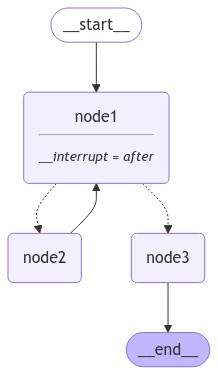

In [2]:
class State(TypedDict):
    input: str
    messages: Annotated[list, add_messages]


def node1(state:State):
    print("Inside node 1")
    state["messages"]=state["input"]
    return state 


def node2(state:State):
    print("Inside node2")
    state["messages"]=["My name is node 2"]
    return state 



def node3(state:State):
    print("Inside node3")
    state["messages"]=["My name is node 3"]
    return state 


def should_continue(state:State):
    messages = state['messages']
    last_message = messages[-1]
    print("should_continue,last_message",last_message)
    # If the LLM makes a tool call, then we route to the "tools" node
    
    if last_message.content=="go to node2":
        print("continue to:","node2")
        return "node2"
    
    else:
        print("continue to:","node3")
        return "node3"


builder = StateGraph(State)
builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)
builder.set_entry_point("node1") 


builder.add_conditional_edges(
    "node1",
    should_continue,
    {"node3": "node3", "node2": "node2"},
    )        

builder.add_edge("node2", "node1")

builder.add_edge("node3", END)

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory,interrupt_after=["node1"])

# View
display(Image(graph.get_graph().draw_mermaid_png()))

# Run graph with invoke 

Graph ends before node2 or before node3.

In [4]:
try:
    user_input = input("what next?")
except:
    user_input = "End"
    
thread = {"configurable": {"thread_id": "1"}}
state=State()

state["input"]=user_input
# Invoke the graph to process the user input
state = graph.invoke(state, thread)

what next? go to node2


Inside node 1
should_continue,last_message content='go to node2' additional_kwargs={} response_metadata={} id='ffd8b6cf-c501-4b78-98b8-0f9cdb5d3e98'
continue to: node2


# Run graph with stream 

Graph waits after node1

In [5]:
# Get user input, replace this with widget
try:
    user_input = input("what next?")
except:
    user_input = "End"
    
graph_input = {"input": user_input}    
for st in graph.stream(graph_input, thread, stream_mode="values"):
    print(st["messages"][-1].content)
    


what next? go to node2


go to node2
Inside node 1
should_continue,last_message content='go to node2' additional_kwargs={} response_metadata={} id='3b91c545-c0d3-41ac-af4b-c836b000e7e8'
continue to: node2
go to node2



The graph goes to node2 and then back to node1 or directly to node3. However, the last message is still "go to node2".

In [6]:
for st in graph.stream(None, thread, stream_mode="values"):
    print(st["messages"][-1].content) 

go to node2
Inside node2
My name is node 2
Inside node 1
should_continue,last_message content='go to node2' additional_kwargs={} response_metadata={} id='a38d3c62-130c-4a92-bcca-51c26aa63fe4'
continue to: node2
go to node2


# Exercise

1. Enter the user input so that the graph goes to node 2.

2. Enter the user input so that the graph goes directly to node 3.

3. Modify the graph so that node2 continues executing until "go to node3" is entered.

Note: The graph starts from the beginning each time.

In [36]:
# Get user input, replace this with widget
try:
    user_input = input("what next?")
except:
    user_input = "End"
    
graph_input = {"input": user_input}    
for st in graph.stream(graph_input, thread, stream_mode="values"):
    print(st["messages"][-1].content)

for st in graph.stream(None, thread, stream_mode="values"):
    print(st["messages"][-1].content) 

what next? go to node2


My name is node 3
Inside node 1
should_continue,last_message content='go to node2' additional_kwargs={} response_metadata={} id='ad96de3d-1dda-472a-ab74-45657252ea55'
continue to: node2
go to node2
go to node2
Inside node2
My name is node 2
Inside node 1
should_continue,last_message content='go to node2' additional_kwargs={} response_metadata={} id='27fdbfd9-159c-46f8-98c2-691ed6f8f000'
continue to: node2
go to node2


# Panel App




The code is designed to receive user inputs, process them, and display a response. Here is a summary of each part of the code:

### 1. `state=State()`
   - A global `state` object is initialized to store and track information during the processing of user inputs, including the question and generated answers. This suggests that `State` is a custom or predefined class that manages the application’s context and state.

### 2. `input_function`
   - The `input_function` takes a single parameter, `question`, which is expected as a string representing the user’s question.
   - Within the function:
      - The global `state` is updated with the question (`state["input"] = question`).
      - The question is also stored under `state["messages"]`, likely as part of a message sequence or for later reference.
      - A hypothetical function `graph.invoke()` is called, presumably processing the question by interacting with a system (such as an AI model, computation graph, or other processing unit). The `thread` dictionary may contain parameters necessary for processing, like `thread_id`.
      - The function extracts the answer from the `state["messages"]` array (assuming the last entry contains the answer), outputs it for debugging, and returns it as the function’s result.

### 3. Widget Setup
   - `question`: A `TextInput` widget from Panel, allowing users to enter their question. This widget is labeled “Input here please.”
   - `output`: A Markdown panel that will be updated with the answer to the question.

### 4. `button_click`
   - The `button_click` function handles the button’s click event:
      - It checks if the `answer_button` has been clicked.
      - If so, it binds `input_function` to the `question` widget with `pn.bind()`, dynamically passing the question input when the button is clicked.
      - It then attempts to call `input_function` and stores the result in `output`, displaying the answer in a Markdown panel. If an error occurs, the error message is displayed instead.

### 5. Setting Up the Answer Button
   - `answer_button`: A Button widget from Panel, configured to call `button_click` when clicked.

### 6. Layout and Display
   - `Tab`: A layout that arranges the input field, answer button, separator, and answer display (in Markdown format) in a column and stretches everything to full width.
   - `layout`: This final layout embeds `Tab` in a tab display within the Panel layout, making it user-friendly.

### Summary
This code creates an interactive, Panel-based application that allows users to enter a question, process it through an external `graph.invoke()` function, and display the answer. The `state` object tracks user inputs and answers, while the Panel widgets provide a user-friendly interface for interaction.


In [7]:
state=State()
def input_function(question:str):
    global state
    thread = {"configurable": {"thread_id": "1"}}  

    state["input"]=question
    state["messages"]=question
    
    # Invoke the graph to process the user question
    state = graph.invoke(state, thread)
    answer="the last message from agent is: "+state["messages"][-1].content
    print("input_function",answer)
    return answer

## Widget für die Eingabe
question = pn.widgets.TextInput(name="Input here please", placeholder="Task", sizing_mode="stretch_width")
## Panel für die AUsgabe
output = pn.pane.Markdown("Answer")

## Funktion, welche bei buttzon_click der input_function die Frage, welche in das Widget eingegebn wurde übergibt. 
## Das Resultat von input_function wird an den output übetragen, weler in der App angezeigt wird 
def button_click(event):
    if answer_button.clicks > 0:
        bound_function = pn.bind(input_function, question)
        try:
            result = bound_function()
            output.object = f"Start answer:\n {result}"
        except Exception as e:
             output.object = f"Error in start_button_click: {e}"

answer_button = pn.widgets.Button(name="Answer", button_type="primary", width=50, height=50)
answer_button.on_click(button_click)

Tab = pn.Column(
            pn.Row(question),
            pn.panel(answer_button, loading_indicator=True, height=50),
            pn.layout.Divider(),
            pn.panel(output, loading_indicator=True, height=900),
            sizing_mode="stretch_width"
        )


layout = pn.Column(pn.Tabs(('Answer', Tab)))
layout.show()

Launching server at http://localhost:54275


Inside node 1
should_continue,last_message content='go to node2' additional_kwargs={} response_metadata={} id='5226e28c-0a7e-450c-a7f8-970b6ed86b55'
continue to: node2
input_function the last message from agent is: go to node2
Inside node 1
should_continue,last_message content='' additional_kwargs={} response_metadata={} id='29ae6d48-fa0f-4885-9d67-0f170d278797'
continue to: node3
input_function the last message from agent is: 


# Exercise



Why is it not possible to reach node 2 with this app?


# Exercise

Change the app to perform as follows:

At node1 the user decides if the graph runs to node 2 or node 3. 
If the graph runs to node2, it automatically runs back to node 1 and waits for the user input that decides to either run to node 2 or node 3.

## Solution

In [9]:
question = pn.widgets.TextInput(name="Input here please", placeholder="Task", sizing_mode="stretch_width")
output = pn.pane.Markdown("Answer")  # This will display the answer text

# Function to handle input and update the output
def input_function(event):
    thread = {"configurable": {"thread_id": "1"}} 
    # If input is empty, go to node2
    if question.value:
        input = {"input": question.value,"messages": question.value}
    else:
        input={"input": "go to node2","messages": "go to node2"}
    
    for st in graph.stream(input, thread, stream_mode="values"):
        answer=st["messages"][-1].content
    for st in graph.stream(None, thread, stream_mode="values"):
        answer=st["messages"][-1].content    
    output.object = f"**Answer:**\n\n{answer}"  # Update output with the answer

# Set up the answer button and bind the function
answer_button = pn.widgets.Button(name="Answer", button_type="primary")
answer_button.on_click(input_function)

# Layout with question input, answer button, and output display
Tab = pn.Column(
    pn.Row(question),
    pn.panel(answer_button, loading_indicator=True, height=50),
    pn.layout.Divider(),
    pn.panel(output, loading_indicator=True, height=900),
    sizing_mode="stretch_width"
)

layout = pn.Column(pn.Tabs(('Answer', Tab)))
layout.show()

Launching server at http://localhost:54314


Inside node 1
should_continue,last_message content='go to node2' additional_kwargs={} response_metadata={} id='f03e6876-0480-4f6c-8c6c-764bebaaf228'
continue to: node2
Inside node2
Inside node 1
should_continue,last_message content='go to node2' additional_kwargs={} response_metadata={} id='eeebcfac-da8b-442e-ba6c-adddf7d133ce'
continue to: node2
